# **Between U-Net and U-Net++**
We investigate alternative architectures between U-Net and U-Net++ and evaluate them on a simple brain extraction dataset.

# **Dependencies and Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%%capture
!pip install monai # for loss & metrics
!pip install torchio # for data augmentation

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import gc
import monai
import torchio as tio
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
ids_Guys = np.load('/content/drive/MyDrive/healthcare_data/brain_extraction/ids_Guys.npy')
ids_IOP = np.load('/content/drive/MyDrive/healthcare_data/brain_extraction/ids_IOP.npy')
ids_HH = np.load('/content/drive/MyDrive/healthcare_data/brain_extraction/ids_HH.npy')

In [ ]:
# There is no overlap in ids so we can combine all three datasets
print(set(ids_Guys).intersection(set(ids_IOP)))
print(set(ids_Guys).intersection(set(ids_HH)))
print(set(ids_IOP).intersection(set(ids_HH)))

set()
set()
set()


In [3]:
X_Guys = np.load('/content/drive/MyDrive/healthcare_data/brain_extraction/X_Guys.npy')
X_IOP = np.load('/content/drive/MyDrive/healthcare_data/brain_extraction/X_IOP.npy')
X_HH = np.load('/content/drive/MyDrive/healthcare_data/brain_extraction/X_HH.npy')
print(X_Guys.shape)
print(X_IOP.shape)
print(X_HH.shape)
X = np.concatenate([X_Guys, X_IOP, X_HH])
print(X.shape)

del X_Guys, X_IOP, X_HH # clear to preserve RAM
gc.collect()

y_Guys = np.load('/content/drive/MyDrive/healthcare_data/brain_extraction/y_Guys.npy')
y_IOP = np.load('/content/drive/MyDrive/healthcare_data/brain_extraction/y_IOP.npy')
y_HH = np.load('/content/drive/MyDrive/healthcare_data/brain_extraction/y_HH.npy')
y = np.concatenate([y_Guys, y_IOP, y_HH])

del y_Guys, y_IOP, y_HH # clear to preserve RAM
gc.collect()

# Note we take slices after augmentation applied since some require volume
# Quarter the volume - should be enough for augmentations like affine
X = X[:, 15:25, ...]
y = y[:, 15:25, ...]

gc.collect()

(317, 40, 128, 128)
(71, 40, 128, 128)
(176, 40, 128, 128)
(564, 40, 128, 128)


0

In [4]:
N = X.shape[0]

# Seed so same dataset every time
np.random.seed(0)

# Shuffle the 3D images so we don't have Guys, followed by IOP, followed by HH
shuffled_indices = np.random.permutation(N)
X = X[shuffled_indices]
y = y[shuffled_indices]

# Halve the dataset size so cross validation is viable with Colab runtime limits
X = X[:300]
y = y[:300]

del shuffled_indices
gc.collect()

0

In [5]:
# Augmentation code adapted from https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/Data_preprocessing_and_augmentation_using_TorchIO_a_tutorial.ipynb
def make_dataset(data, target, augment=False):
    N = data.shape[0]
    subjects = []
    for i in range(N):
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=np.expand_dims(data[i], axis=0)),
            label=tio.LabelMap(tensor=np.expand_dims(target[i], axis=0))
        )
        subjects.append(subject)
    normalise = tio.ZNormalization() # normalisation to zero mean and 1 std per image
    augmentation = tio.Compose([
        tio.RandomBlur(p=0.25),                         # blur 25% of times
        tio.RandomNoise(p=0.25),                        # Gaussian noise 25% of times
        tio.OneOf({                                     # either
            tio.RandomAffine(degrees=5): 0.8,           # random affine
            tio.RandomElasticDeformation(5, 2): 0.2,    # or random elastic deformation
        }, p=0.8),                                      # applied to 80% of images
        tio.RandomBiasField(p=0.3),                     # magnetic field inhomogeneity 30% of times
        tio.OneOf({                                     # either
            tio.RandomMotion(): 1,                      # random motion artifact
            tio.RandomSpike(): 2,                       # or spikes
            tio.RandomGhosting(): 2,                    # or ghosts
        }, p=0.5),                                      # applied to 50% of images
    ])
    if augment:
        return tio.SubjectsDataset(subjects, transform=tio.Compose([augmentation, normalise, tio.OneHot()]))
    else:
        return tio.SubjectsDataset(subjects, transform=tio.Compose([normalise, tio.OneHot()]))

Some example augmentations.

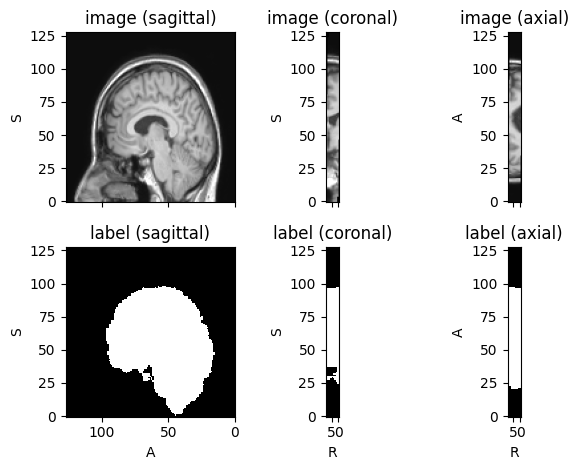

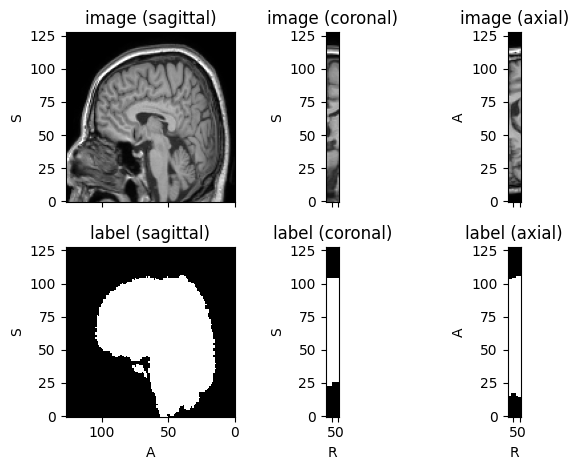

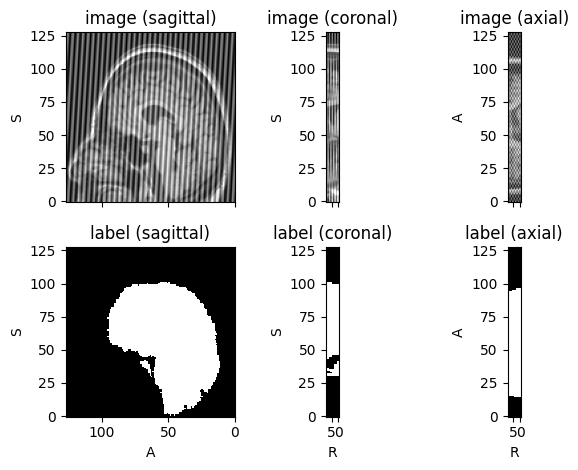

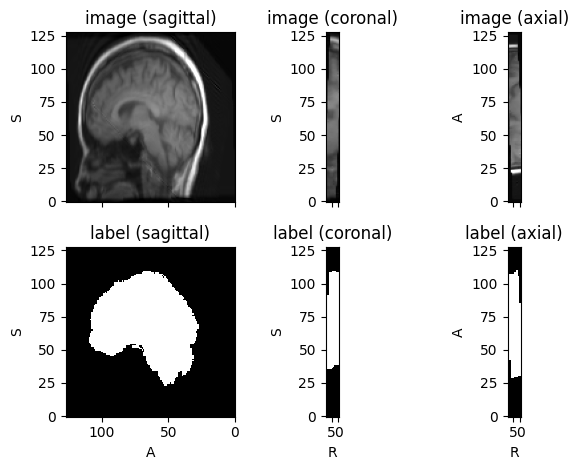

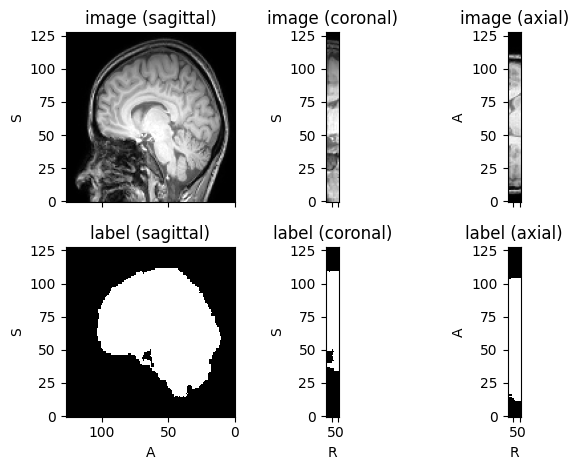

In [ ]:
test = make_dataset(X, y, augment=True)
test[0].plot()
test[1].plot()
test[2].plot()
test[3].plot()
test[4].plot()

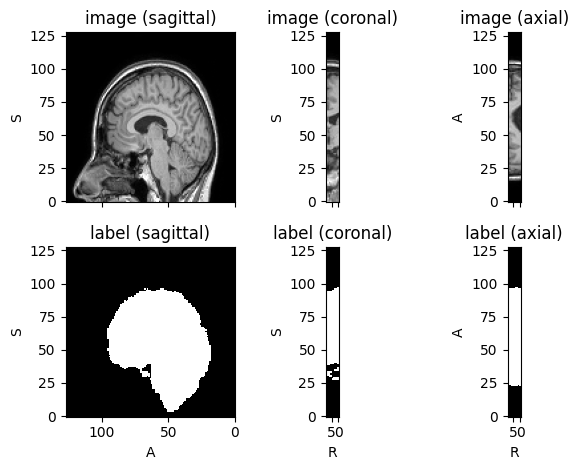

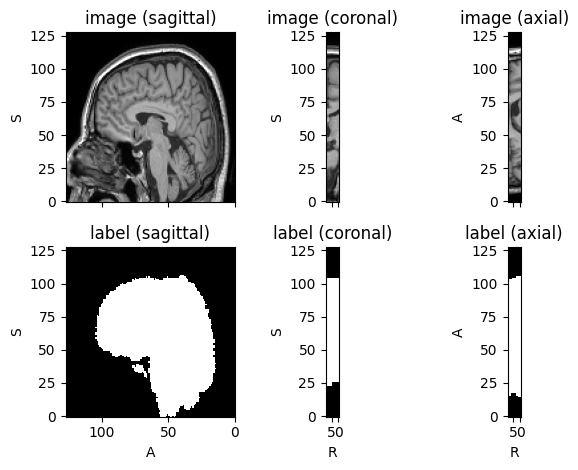

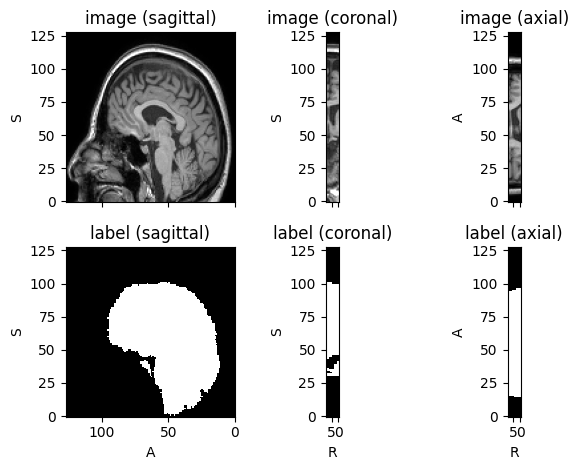

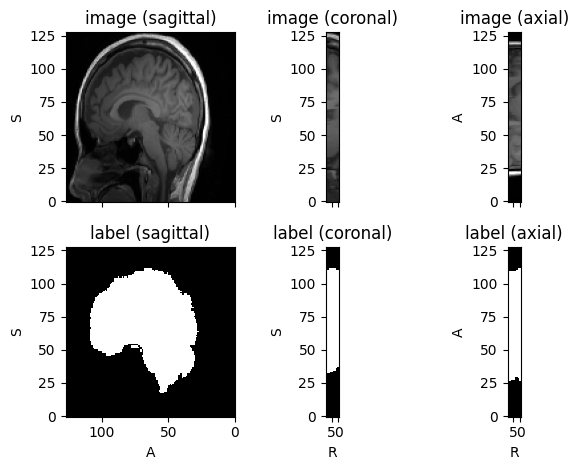

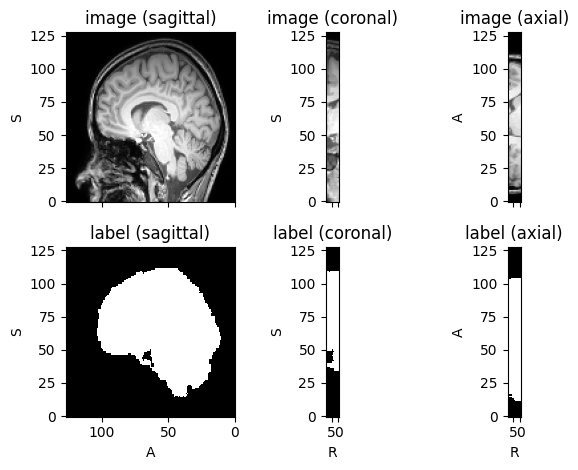

In [ ]:
test2 = make_dataset(X, y, augment=False)
test2[0].plot()
test2[1].plot()
test2[2].plot()
test2[3].plot()
test2[4].plot()

# **Experiment**

## **Training**

In [6]:
def prepare_batch(batch):
    data, target = batch["image"][tio.DATA].to(device), batch["label"][tio.DATA].to(device)
    n = data.shape[2]
    return data[:, :, n//2, ...], target[:, :, n//2, ...] # take central slice

In [7]:
def train_epoch(model, dataloader, loss_fn, optimiser):
    model.train()
    total_loss = 0

    for batch in dataloader:
        data, target = prepare_batch(batch)

        optimiser.zero_grad()
        pred = model(data)
        loss = loss_fn(pred, target)
        loss.backward()
        optimiser.step()

        batch_size = data.shape[0]
        total_loss += loss.item() * batch_size
    
    mean_loss = total_loss / len(dataloader.dataset)
    return mean_loss

## **Validation**

In [8]:
def validate(model, dataloader, loss_fn, optimiser):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            data, target = prepare_batch(batch)

            pred = model(data)
            loss = loss_fn(pred, target)

            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
        
    mean_loss = total_loss / len(dataloader.dataset)
    return mean_loss

## **Testing**

In [9]:
def test(model, dataloader):    
    model.eval()

    get_iou = monai.metrics.MeanIoU(include_background=False, reduction="sum")
    get_hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="sum")
    total_iou = 0
    total_hd = 0
    with torch.no_grad():
        for batch in dataloader:
            data, target = prepare_batch(batch)

            pred = model(data)
            labels = pred.argmax(dim=1)
            labels_one_hot = F.one_hot(labels).permute(0, 3, 1, 2)

            get_iou(labels_one_hot, target)
            iou = get_iou.aggregate().item()
            get_iou.reset()
            total_iou += iou

            get_hd(labels_one_hot, target)
            hd = get_hd.aggregate().item()
            get_hd.reset()
            total_hd += hd

    mean_iou = total_iou / len(dataloader.dataset)
    mean_hd = total_hd / len(dataloader.dataset)
    return mean_iou, mean_hd

## **Cross Validation**

In [10]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [11]:
def cross_validate(model, X, y, k=5, patience=5, epochs=100):
    N = X.shape[0]

    mean_ious = []
    mean_hds = []

    train_losses = []
    val_losses = []

    for fold in range(k):
        print(f"Fold {fold+1}")
        print("============================")
        print()

        # Seed for model initialisation
        set_seed(fold)

        model.reset_parameters()

        # Calculate the current fold segment indices
        test_index_min = (N * fold) // k
        test_index_max = (N * (fold + 1)) // k


        # Split into development set and test set
        X_dev = np.concatenate([X[test_index_min:, ...], X[:test_index_max, ...]])
        y_dev = np.concatenate([y[test_index_min:, ...], y[:test_index_max, ...]])
        X_test = X[test_index_min:test_index_max, ...]
        y_test = y[test_index_min:test_index_max, ...]

        # Split development set into training and validation set
        dev_size = X_dev.shape[0]
        train_size = int(0.75 * dev_size)
        X_train = X_dev[:train_size, ...]
        y_train = y_dev[:train_size, ...]
        X_val = X_dev[train_size:, ...]
        y_val = y_dev[train_size:, ...]

        del X_dev, y_dev
        gc.collect()

        train_dataset = make_dataset(X_train, y_train, augment=True)
        val_dataset = make_dataset(X_val, y_val, augment=False)
        test_dataset = make_dataset(X_test, y_test, augment=False)

        # Seed for dataloader shuffle + augmentations
        set_seed(fold)

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=16,
            shuffle=True,
        )
        val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=16,
            shuffle=False,
        )
        test_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=16,
            shuffle=False,
        )

        loss_fn = monai.losses.DiceCELoss(softmax=True)
        optimiser = torch.optim.Adam(model.parameters())

        # Train model
        fold_train_losses = []
        fold_val_losses = []
        patience_counter = 0

        best_val_loss = None
        for epoch in range(epochs):
            train_loss = train_epoch(model, train_dataloader, loss_fn, optimiser)
            val_loss = validate(model, val_dataloader, loss_fn, optimiser)

            fold_train_losses.append(train_loss)
            fold_val_losses.append(val_loss)

            print(f"Epoch {epoch+1}")
            print("============================")
            print(f"Train loss: {train_loss}")
            print(f"Validation loss: {val_loss}")
            print()

            if best_val_loss is None or val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'best_model_{fold}.pth')
            else:
                patience_counter += 1
            
            if patience_counter == patience:
                print(f"Early stopped")
                print()
                break
        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)

        # Test best model
        model.load_state_dict(torch.load(f'best_model_{fold}.pth'))

        mean_iou, mean_hd = test(model, test_dataloader)
        mean_ious.append(mean_iou)
        mean_hds.append(mean_hd)
        
        print(f"Test results")
        print("============================")
        print(f"Mean IoU: {mean_iou}")
        print(f"Mean Hausdorff Distance: {mean_hd}")
    
    return train_losses, val_losses, mean_ious, mean_hds

# **Models**

## **U-Net**

In [ ]:
from collections import OrderedDict

class UNet(nn.Module):
    def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNet, self).__init__()

        self.pool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.encoder1 = UNet._block(in_channels, init_features, 'encoder1')
        self.encoder2 = UNet._block(init_features, 2*init_features, 'encoder2')
        self.encoder3 = UNet._block(2*init_features, 4*init_features, 'encoder3')
        self.bottleneck = UNet._block(4*init_features, 8*init_features, 'bottleneck')
        self.decoder3 = UNet._block(12*init_features, 4*init_features, 'decoder3')
        self.decoder2 = UNet._block(6*init_features, 2*init_features, 'decoder2')
        self.decoder1 = UNet._block(3*init_features, init_features, 'decoder1')
        self.conv = nn.Conv2d(init_features, out_channels, 3, padding='same')

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(self.pool(x1))
        x3 = self.encoder3(self.pool(x2))
        x4 = self.bottleneck(self.pool(x3))
        x3_inv = self.decoder3(torch.cat([self.upsample(x4), x3], dim=1))
        x2_inv = self.decoder2(torch.cat([self.upsample(x3), x2], dim=1))
        x1_inv = self.decoder1(torch.cat([self.upsample(x2), x1], dim=1))
        x = self.conv(x1_inv)
        return F.softmax(x, dim=1)

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [(f'{name}-conv', nn.Conv2d(in_channels, features, 3, padding='same')),
                 (f'{name}-relu', nn.ReLU()),
                 (f'{name}-norm', nn.BatchNorm2d(features))
                ]))

In [ ]:
unet = UNet().to(device)
unet_train_losses, unet_val_losses, unet_mean_ious, unet_mean_hds = cross_validate(unet, X, y)

Fold 1

Epoch 1
Train loss: 1.0942595396962131
Validation loss: 1.0326398238440453

Epoch 2
Train loss: 0.9437471534368647
Validation loss: 0.8469748353354944

Epoch 3
Train loss: 0.8715803596705984
Validation loss: 0.8086522797967122

Epoch 4
Train loss: 0.8484540095637545
Validation loss: 0.7908535090155554

Epoch 5
Train loss: 0.809938108392301
Validation loss: 0.7727713451352388

Epoch 6
Train loss: 0.8170169170424727
Validation loss: 0.7727343962427804

Epoch 7
Train loss: 0.805587642485153
Validation loss: 0.7664269898995992

Epoch 8
Train loss: 0.7925975088137056
Validation loss: 0.766202623586052

Epoch 9
Train loss: 0.7961458649091111
Validation loss: 0.764590626969937

Epoch 10
Train loss: 0.7856546968872543
Validation loss: 0.7593244672000986

Epoch 11
Train loss: 0.7823524268088885
Validation loss: 0.7480532091567235

Epoch 12
Train loss: 0.7864303744758003
Validation loss: 0.7400873491489438

Epoch 13
Train loss: 0.7751478003845199
Validation loss: 0.7409509122781108

Epoc

/usr/local/lib/python3.9/dist-packages/monai/metrics/hausdorff_distance.py:170: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


Test results
Mean IoU: 0.7373483799121998
Mean Hausdorff Distance: inf
Fold 3

Epoch 1
Train loss: 0.9663675239587085
Validation loss: 0.8198068926539547

Epoch 2
Train loss: 0.8294921635925011
Validation loss: 0.7737670296594454

Epoch 3
Train loss: 0.7881389983601288
Validation loss: 0.7508071753024594

Epoch 4
Train loss: 0.7783683148455012
Validation loss: 0.7424353679203067

Epoch 5
Train loss: 0.7713455891608317
Validation loss: 0.7315678648721263

Epoch 6
Train loss: 0.7643199976587348
Validation loss: 0.7490005214785447

Epoch 7
Train loss: 0.7631307954085489
Validation loss: 0.7276061295912094

Epoch 8
Train loss: 0.7749681281244777
Validation loss: 0.7225675813005957

Epoch 9
Train loss: 0.7553497659651794
Validation loss: 0.7208675270474959

Epoch 10
Train loss: 0.7603085253523909
Validation loss: 0.7342669823076743

Epoch 11
Train loss: 0.7593762251613131
Validation loss: 0.7277568924647566

Epoch 12
Train loss: 0.755870328398431
Validation loss: 0.7192468374937142

Epoch 1

Note that the higher training loss is expected due to the augmentations.

In [16]:
def metrics(model, name, train_losses, val_losses, mean_ious, mean_hds, epochs):
    # In case of early stopping, extend accuracy/error/loss list by duplicating the
    # last element until the list has length equal to the number of epochs
    def extend(lst_of_lsts):
        for i, lst in enumerate(lst_of_lsts):
            if len(lst) < epochs:
                lst_of_lsts[i] = lst + ([lst[-1]] * (epochs - len(lst)))
        return lst_of_lsts

    train_losses = list(map(np.mean, zip(*extend(train_losses))))
    val_losses = list(map(np.mean, zip(*extend(val_losses))))

    plt.plot(train_losses, label="train") # blue
    plt.plot(val_losses, label="validation") # orange
    plt.legend()
    plt.show()

    mean_hds = [hd for hd in mean_hds if hd != float('inf')]
    
    print(f"{name} Metrics")
    print("============================")
    print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Mean IoU: {np.mean(mean_ious):.2f} +/- {np.std(mean_ious):.2f}")
    print(f"Mean Hausdorff Distance: {np.mean(mean_hds):.2f} +/- {np.std(mean_hds):.2f}")

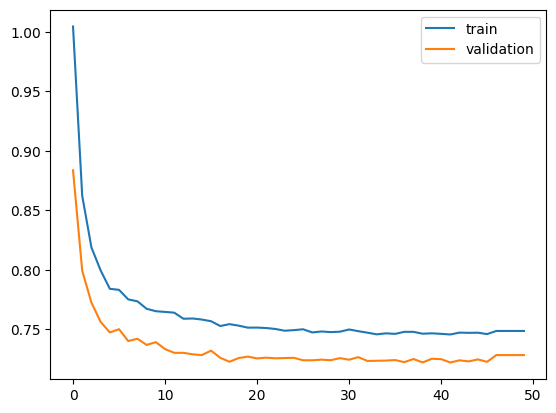

U-Net Metrics
Trainable Parameters: 15494
Mean IoU: 0.74 +/- 0.01
Mean Hausdorff Distance: 41.50 +/- 0.29


In [ ]:
metrics(unet, "U-Net", unet_train_losses, unet_val_losses, unet_mean_ious, unet_mean_hds, 50)

In [17]:
mean_ious = [0.7266593191358778, 0.7373483799121998, 0.7442986806233723, 0.7540110270182292, 0.7366753966720015]
print(f"Mean IoU: {np.mean(mean_ious) * 100:.2f} +/- {np.std(mean_ious)* 100:.2f}")

Mean IoU: 73.98 +/- 0.91


## **Wide U-Net**

In [ ]:
unet = UNet(init_features=5).to(device)
unet_train_losses, unet_val_losses, unet_mean_ious, unet_mean_hds = cross_validate(unet, X, y)

Fold 1

Epoch 1
Train loss: 1.066038710392005
Validation loss: 1.0227748235281193

Epoch 2
Train loss: 0.9275633688469428
Validation loss: 0.8339006970102016

Epoch 3
Train loss: 0.8748146845545093
Validation loss: 0.7966866788214488

Epoch 4
Train loss: 0.8499090473276074
Validation loss: 0.7850567785603002

Epoch 5
Train loss: 0.8080088523837615
Validation loss: 0.7789313960547677

Epoch 6
Train loss: 0.8123316776936342
Validation loss: 0.765658811841788

Epoch 7
Train loss: 0.798734536072215
Validation loss: 0.7666600173267406

Epoch 8
Train loss: 0.7854934101969585
Validation loss: 0.763189403791405

Epoch 9
Train loss: 0.7861411604641922
Validation loss: 0.7668005465860545

Epoch 10
Train loss: 0.7778857683169167
Validation loss: 0.744290176017095

Epoch 11
Train loss: 0.7767003634366115
Validation loss: 0.7554504804038272

Epoch 12
Train loss: 0.781229322037035
Validation loss: 0.7334730098014229

Epoch 13
Train loss: 0.7675852411903944
Validation loss: 0.7340238544193599

Epoch 

/usr/local/lib/python3.9/dist-packages/monai/metrics/hausdorff_distance.py:170: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


Test results
Mean IoU: 0.7367669034887243
Mean Hausdorff Distance: inf
Fold 2

Epoch 1
Train loss: 0.8907664179322422
Validation loss: 0.7935045103682044

Epoch 2
Train loss: 0.803060569495617
Validation loss: 0.7461698597635925

Epoch 3
Train loss: 0.7798903766738281
Validation loss: 0.7600976392193661

Epoch 4
Train loss: 0.775068434598051
Validation loss: 0.7346962924964452

Epoch 5
Train loss: 0.7609913480894385
Validation loss: 0.7386443922364827

Epoch 6
Train loss: 0.762599610612611
Validation loss: 0.7451280424846014

Epoch 7
Train loss: 0.7543639497147524
Validation loss: 0.7273681716267295

Epoch 8
Train loss: 0.7632355896070728
Validation loss: 0.7370964043803188

Epoch 9
Train loss: 0.7562481900333848
Validation loss: 0.7258408559879818

Epoch 10
Train loss: 0.7475109581179463
Validation loss: 0.7361951571426288

Epoch 11
Train loss: 0.7509826278081244
Validation loss: 0.7253056314711606

Epoch 12
Train loss: 0.7443979586122548
Validation loss: 0.7285714135051606

Epoch 13


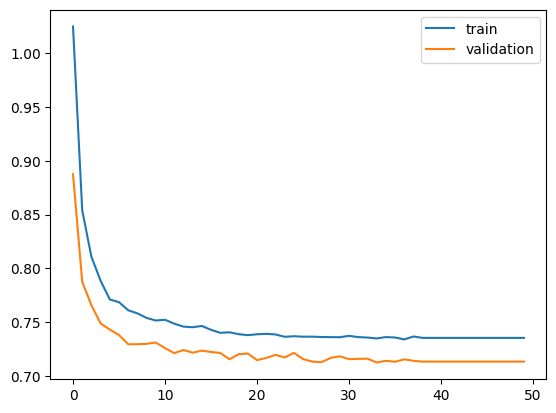

Wide U-Net Metrics
Trainable Parameters: 24092
Mean IoU: 0.76 +/- 0.01
Mean Hausdorff Distance: 41.14 +/- 0.24


In [ ]:
metrics(unet, "Wide U-Net", unet_train_losses, unet_val_losses, unet_mean_ious, unet_mean_hds, 50)

In [18]:
mean_ious = [0.7367669034887243, 0.7735009687918204, 0.76426117155287, 0.768959003024631, 0.7693461347509314]
print(f"Mean IoU: {np.mean(mean_ious) * 100:.2f} +/- {np.std(mean_ious)* 100:.2f}")

Mean IoU: 76.26 +/- 1.32


## **U-Net-Top-A**

In [ ]:
class UNetTopA(nn.Module):
    def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNetTopA, self).__init__()

        self.pool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv00 = self._block(in_channels, init_features)
        self.conv01 = self._block(2*init_features, init_features)
        self.conv02 = self._block(2*init_features, init_features)
        self.conv03 = self._block(5*init_features, init_features)
        self.conv10 = self._block(init_features, 2*init_features)
        self.conv11 = self._block(4*init_features, 2*init_features)
        self.conv12 = self._block(4*init_features, 2*init_features)
        self.conv20 = self._block(2*init_features, 4*init_features)
        self.conv21 = self._block(8*init_features, 4*init_features)
        self.conv30 = self._block(4*init_features, 8*init_features)
        self.out_conv = nn.Conv2d(init_features, out_channels, 3, padding='same')

    def forward(self, x):
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x01 = self.conv01(self.upsample(x10))
        x11 = self.conv11(self.upsample(x20))
        x21 = self.conv21(self.upsample(x30))
        x02 = self.conv02(self.upsample(x11))
        x12 = self.conv12(self.upsample(x21))
        x03 = self.conv03(torch.cat([x00, x01, x02, self.upsample(x12)], dim=1))
        x = self.out_conv(x03)
        return F.softmax(x, dim=1)

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(features))

In [ ]:
unet_top_a = UNetTopA().to(device)
unet_top_a_train_losses, unet_top_a_val_losses, unet_top_a_mean_ious, unet_top_a_mean_hds = cross_validate(unet_top_a, X, y)

Fold 1

Epoch 1
Train loss: 1.0124077943203365
Validation loss: 0.973397845076139

Epoch 2
Train loss: 0.8303421764824973
Validation loss: 0.7297693738910793

Epoch 3
Train loss: 0.751030750139248
Validation loss: 0.6994104460081149

Epoch 4
Train loss: 0.7209826722526218
Validation loss: 0.6957531592951804

Epoch 5
Train loss: 0.6932543913325214
Validation loss: 0.6726130422175569

Epoch 6
Train loss: 0.6905304596152717
Validation loss: 0.6578484605177147

Epoch 7
Train loss: 0.6843073213447532
Validation loss: 0.655602380395551

Epoch 8
Train loss: 0.6706727941882797
Validation loss: 0.6537754765774844

Epoch 9
Train loss: 0.6709986538901197
Validation loss: 0.6496342739585832

Epoch 10
Train loss: 0.6659792796063522
Validation loss: 0.6525620037515771

Epoch 11
Train loss: 0.6617940420189503
Validation loss: 0.6445500953222422

Epoch 12
Train loss: 0.662016297909057
Validation loss: 0.6433097755523612

Epoch 13
Train loss: 0.6560211087230838
Validation loss: 0.6402645884228945

Epoc

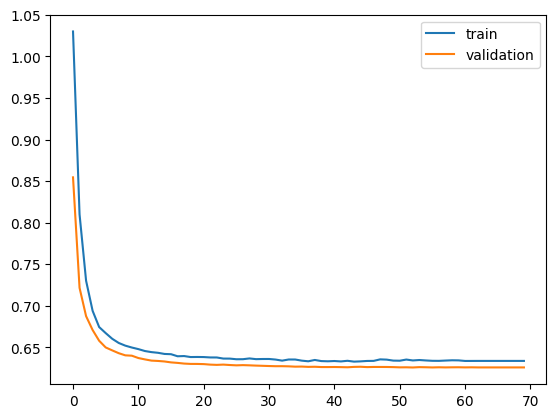

U-Net-Top-A Metrics
Trainable Parameters: 14678
Mean IoU: 0.94 +/- 0.00
Mean Hausdorff Distance: 8.06 +/- 1.51


In [ ]:
metrics(unet_top_a, "U-Net-Top-A", unet_top_a_train_losses, unet_top_a_val_losses, unet_top_a_mean_ious, unet_top_a_mean_hds, 70)

In [19]:
mean_ious = [0.9313763088650173, 0.937870036231147, 0.9400627030266656, 0.9428839718853986, 0.9434224375972041]
print(f"Mean IoU: {np.mean(mean_ious) * 100:.2f} +/- {np.std(mean_ious)* 100:.2f}")

Mean IoU: 93.91 +/- 0.44


## **U-Net-Top-B**

In [ ]:
class UNetTopB(nn.Module):
    def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNetTopB, self).__init__()

        self.pool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv00 = self._block(in_channels, init_features)
        self.conv01 = self._block(3*init_features, init_features)
        self.conv02 = self._block(3*init_features, init_features)
        self.conv03 = self._block(3*init_features, init_features)
        self.conv10 = self._block(init_features, 2*init_features)
        self.conv11 = self._block(4*init_features, 2*init_features)
        self.conv12 = self._block(4*init_features, 2*init_features)
        self.conv20 = self._block(2*init_features, 4*init_features)
        self.conv21 = self._block(8*init_features, 4*init_features)
        self.conv30 = self._block(4*init_features, 8*init_features)
        self.out_conv = nn.Conv2d(init_features, out_channels, 3, padding='same')

    def forward(self, x):
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x01 = self.conv01(torch.cat([x00, self.upsample(x10)], dim=1))
        x11 = self.conv11(self.upsample(x20))
        x21 = self.conv21(self.upsample(x30))
        x02 = self.conv02(torch.cat([x01, self.upsample(x11)], dim=1))
        x12 = self.conv12(self.upsample(x21))
        x03 = self.conv03(torch.cat([x02, self.upsample(x12)], dim=1))
        x = self.out_conv(x03)
        return F.softmax(x, dim=1)

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(features))

In [ ]:
unet_top_b = UNetTopB().to(device)
unet_top_b_train_losses, unet_top_b_val_losses, unet_top_b_mean_ious, unet_top_b_mean_hds = cross_validate(unet_top_b, X, y)

Fold 1

Epoch 1
Train loss: 1.0382295026239687
Validation loss: 0.9973509918068214

Epoch 2
Train loss: 0.8459487399053879
Validation loss: 0.7432519326636108

Epoch 3
Train loss: 0.7751828725406505
Validation loss: 0.705605531791475

Epoch 4
Train loss: 0.7397578760402883
Validation loss: 0.701425872921093

Epoch 5
Train loss: 0.7046510637685669
Validation loss: 0.6748114355352105

Epoch 6
Train loss: 0.6988884850117248
Validation loss: 0.6754105778332634

Epoch 7
Train loss: 0.6941832729070815
Validation loss: 0.6619600428580751

Epoch 8
Train loss: 0.6831941663656976
Validation loss: 0.6598484766370879

Epoch 9
Train loss: 0.6759700338739245
Validation loss: 0.6517225377109803

Epoch 10
Train loss: 0.6717142682832405
Validation loss: 0.6485151168255548

Epoch 11
Train loss: 0.6684565422366358
Validation loss: 0.6478525556127782

Epoch 12
Train loss: 0.6680650994660121
Validation loss: 0.6469630859932654

Epoch 13
Train loss: 0.6664856970186025
Validation loss: 0.6434654692073528

Ep

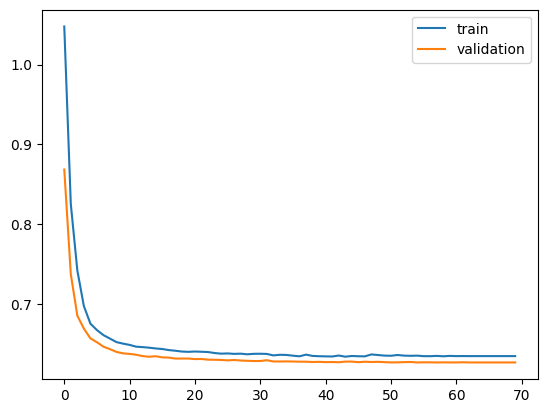

U-Net-Top-B Metrics
Trainable Parameters: 14678
Mean IoU: 0.94 +/- 0.01
Mean Hausdorff Distance: 8.18 +/- 1.69


In [ ]:
metrics(unet_top_b, "U-Net-Top-B", unet_top_b_train_losses, unet_top_b_val_losses, unet_top_b_mean_ious, unet_top_b_mean_hds, 70)

In [20]:
mean_ious = [0.9290974617004395, 0.934390491909451, 0.9410874048868815, 0.9418271983111346, 0.9425214166994448]
print(f"Mean IoU: {np.mean(mean_ious) * 100:.2f} +/- {np.std(mean_ious)* 100:.2f}")

Mean IoU: 93.78 +/- 0.52


## **U-Net-Top-C**

In [ ]:
class UNetTopC(nn.Module):
    def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNetTopC, self).__init__()

        self.pool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv00 = self._block(in_channels, init_features)
        self.conv01 = self._block(3*init_features, init_features)
        self.conv02 = self._block(4*init_features, init_features)
        self.conv03 = self._block(5*init_features, init_features)
        self.conv10 = self._block(init_features, 2*init_features)
        self.conv11 = self._block(4*init_features, 2*init_features)
        self.conv12 = self._block(4*init_features, 2*init_features)
        self.conv20 = self._block(2*init_features, 4*init_features)
        self.conv21 = self._block(8*init_features, 4*init_features)
        self.conv30 = self._block(4*init_features, 8*init_features)
        self.out_conv = nn.Conv2d(init_features, out_channels, 3, padding='same')

    def forward(self, x):
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x01 = self.conv01(torch.cat([x00, self.upsample(x10)], dim=1))
        x11 = self.conv11(self.upsample(x20))
        x21 = self.conv21(self.upsample(x30))
        x02 = self.conv02(torch.cat([x00, x01, self.upsample(x11)], dim=1))
        x12 = self.conv12(self.upsample(x21))
        x03 = self.conv03(torch.cat([x00, x01, x02, self.upsample(x12)], dim=1))
        x = self.out_conv(x03)
        return F.softmax(x, dim=1)

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(features))

In [ ]:
unet_top_c = UNetTopC().to(device)
unet_top_c_train_losses, unet_top_c_val_losses, unet_top_c_mean_ious, unet_top_c_mean_hds = cross_validate(unet_top_c, X, y)

Fold 1

Epoch 1
Train loss: 1.036776375914177
Validation loss: 1.091993154624466

Epoch 2
Train loss: 0.848485142099445
Validation loss: 0.7547929175503253

Epoch 3
Train loss: 0.7801975284874075
Validation loss: 0.6937383600904153

Epoch 4
Train loss: 0.7412138442746391
Validation loss: 0.6869121755763847

Epoch 5
Train loss: 0.7096545368818679
Validation loss: 0.6682718569752476

Epoch 6
Train loss: 0.7030875311290878
Validation loss: 0.6628094006020083

Epoch 7
Train loss: 0.6891792601182128
Validation loss: 0.6575271341253544

Epoch 8
Train loss: 0.6831442212318444
Validation loss: 0.6534777135264707

Epoch 9
Train loss: 0.6834555437501866
Validation loss: 0.6520619462845761

Epoch 10
Train loss: 0.669393698076583
Validation loss: 0.6487801285685326

Epoch 11
Train loss: 0.667343436076954
Validation loss: 0.6450675624717359

Epoch 12
Train loss: 0.6700764605572455
Validation loss: 0.6440177204571849

Epoch 13
Train loss: 0.6662293729218013
Validation loss: 0.6435754943381758

Epoch

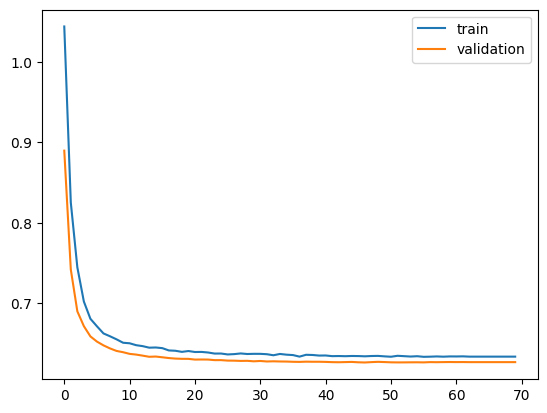

U-Net-Top-C Metrics
Trainable Parameters: 15110
Mean IoU: 0.94 +/- 0.00
Mean Hausdorff Distance: 8.47 +/- 1.46


In [ ]:
metrics(unet_top_c, "U-Net-Top-C", unet_top_c_train_losses, unet_top_c_val_losses, unet_top_c_mean_ious, unet_top_c_mean_hds, 70)

In [21]:
mean_ious = [0.9304250046058937, 0.9340675707216616, 0.9390526347690158, 0.9414930873446994, 0.9417273839314778]
print(f"Mean IoU: {np.mean(mean_ious) * 100:.2f} +/- {np.std(mean_ious)* 100:.2f}")

Mean IoU: 93.74 +/- 0.44


## **U-Net-All-A**

In [ ]:
class UNetAllA(nn.Module):
    def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNetAllA, self).__init__()

        self.pool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv00 = self._block(in_channels, init_features)
        self.conv01 = self._block(2*init_features, init_features)
        self.conv02 = self._block(2*init_features, init_features)
        self.conv03 = self._block(5*init_features, init_features)
        self.conv10 = self._block(init_features, 2*init_features)
        self.conv11 = self._block(4*init_features, 2*init_features)
        self.conv12 = self._block(8*init_features, 2*init_features)
        self.conv20 = self._block(2*init_features, 4*init_features)
        self.conv21 = self._block(12*init_features, 4*init_features)
        self.conv30 = self._block(4*init_features, 8*init_features)
        self.out_conv = nn.Conv2d(init_features, out_channels, 3, padding='same')

    def forward(self, x):
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x01 = self.conv01(self.upsample(x10))
        x11 = self.conv11(self.upsample(x20))
        x21 = self.conv21(torch.cat([x20, self.upsample(x30)], dim=1))
        x02 = self.conv02(self.upsample(x11))
        x12 = self.conv12(torch.cat([x10, x11, self.upsample(x21)], dim=1))
        x03 = self.conv03(torch.cat([x00, x01, x02, self.upsample(x12)], dim=1))
        x = self.out_conv(x03)
        return F.softmax(x, dim=1)

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(features))

In [ ]:
unet_all_a = UNetAllA().to(device)
unet_all_a_train_losses, unet_all_a_val_losses, unet_all_a_mean_ious, unet_all_a_mean_hds = cross_validate(unet_all_a, X, y)

Fold 1

Epoch 1
Train loss: 1.0168358174382734
Validation loss: 0.9820075850812151

Epoch 2
Train loss: 0.8309161582742947
Validation loss: 0.7382492336986444

Epoch 3
Train loss: 0.7451985125776656
Validation loss: 0.684073169188151

Epoch 4
Train loss: 0.7096520327721143
Validation loss: 0.6816092797669563

Epoch 5
Train loss: 0.6843172285907192
Validation loss: 0.6601751840550943

Epoch 6
Train loss: 0.6791883924172201
Validation loss: 0.6559886873183535

Epoch 7
Train loss: 0.6755689640757592
Validation loss: 0.6522120077672091

Epoch 8
Train loss: 0.6642529086986108
Validation loss: 0.650461749516341

Epoch 9
Train loss: 0.6640407122985655
Validation loss: 0.6445633238554396

Epoch 10
Train loss: 0.6590180332711725
Validation loss: 0.6504997828706648

Epoch 11
Train loss: 0.6567699294744853
Validation loss: 0.6412239141734

Epoch 12
Train loss: 0.6557953349793185
Validation loss: 0.6395002931085862

Epoch 13
Train loss: 0.6528789111380824
Validation loss: 0.6421916879168432

Epoch

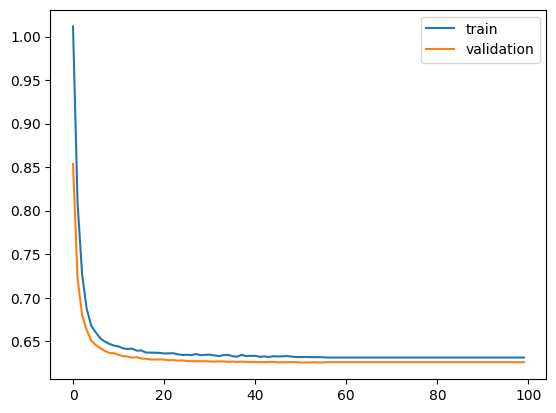

U-Net-All-A Metrics
Trainable Parameters: 18134
Mean IoU: 0.94 +/- 0.00
Mean Hausdorff Distance: 7.51 +/- 0.87


In [ ]:
metrics(unet_all_a, "U-Net-All-A", unet_all_a_train_losses, unet_all_a_val_losses, unet_all_a_mean_ious, unet_all_a_mean_hds, 100)

In [22]:
mean_ious = [0.9373225600631149, 0.9409543214020906, 0.9342688772413466, 0.9426338301764594, 0.9420599796153881]
print(f"Mean IoU: {np.mean(mean_ious) * 100:.2f} +/- {np.std(mean_ious)* 100:.2f}")

Mean IoU: 93.94 +/- 0.32


## **U-Net-All-B**

In [12]:
class UNetAllB(nn.Module):
    def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNetAllB, self).__init__()

        self.pool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv00 = self._block(in_channels, init_features)
        self.conv01 = self._block(3*init_features, init_features)
        self.conv02 = self._block(3*init_features, init_features)
        self.conv03 = self._block(3*init_features, init_features)
        self.conv10 = self._block(init_features, 2*init_features)
        self.conv11 = self._block(6*init_features, 2*init_features)
        self.conv12 = self._block(6*init_features, 2*init_features)
        self.conv20 = self._block(2*init_features, 4*init_features)
        self.conv21 = self._block(12*init_features, 4*init_features)
        self.conv30 = self._block(4*init_features, 8*init_features)
        self.out_conv = nn.Conv2d(init_features, out_channels, 3, padding='same')

    def forward(self, x):
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x01 = self.conv01(torch.cat([x00, self.upsample(x10)], dim=1))
        x11 = self.conv11(torch.cat([x10, self.upsample(x20)], dim=1))
        x21 = self.conv21(torch.cat([x20, self.upsample(x30)], dim=1))
        x02 = self.conv02(torch.cat([x01, self.upsample(x11)], dim=1))
        x12 = self.conv12(torch.cat([x11, self.upsample(x21)], dim=1))
        x03 = self.conv03(torch.cat([x02, self.upsample(x12)], dim=1))
        x = self.out_conv(x03)
        return F.softmax(x, dim=1)

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(features))

In [13]:
unet_all_b = UNetAllB().to(device)
unet_all_b_train_losses, unet_all_b_val_losses, unet_all_b_mean_ious, unet_all_b_mean_hds = cross_validate(unet_all_b, X, y)

Fold 1

Epoch 1
Train loss: 1.0854184958710225
Validation loss: 1.1468853750061228

Epoch 2
Train loss: 0.8885995588826799
Validation loss: 0.7757128663449465

Epoch 3
Train loss: 0.7901436380476649
Validation loss: 0.7007924966819852

Epoch 4
Train loss: 0.7397846440285285
Validation loss: 0.6844250754994202

Epoch 5
Train loss: 0.7058713721418797
Validation loss: 0.6744789095202941

Epoch 6
Train loss: 0.6975750597719544
Validation loss: 0.6657490538910932

Epoch 7
Train loss: 0.6826695324311396
Validation loss: 0.657041099859061

Epoch 8
Train loss: 0.6764485484046049
Validation loss: 0.6530342152238915

Epoch 9
Train loss: 0.6775588635947414
Validation loss: 0.6487552870147385

Epoch 10
Train loss: 0.6653420361289187
Validation loss: 0.6468111215110384

Epoch 11
Train loss: 0.6628944118985103
Validation loss: 0.643803110526184

Epoch 12
Train loss: 0.661253176113308
Validation loss: 0.6433352749793585

Epoch 13
Train loss: 0.658753422184842
Validation loss: 0.6439332758532191

Epoc

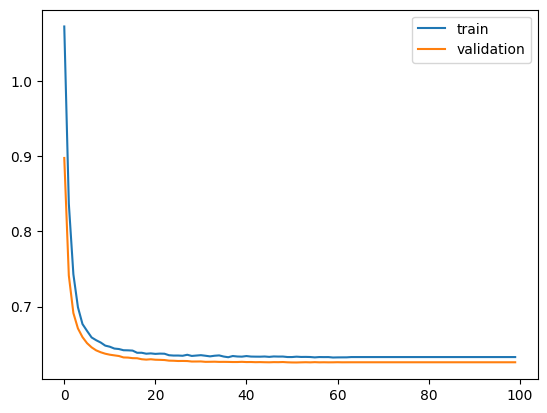

U-Net-All-B Metrics
Trainable Parameters: 18134
Mean IoU: 0.94 +/- 0.00
Mean Hausdorff Distance: 7.70 +/- 1.32


In [23]:
metrics(unet_all_b, "U-Net-All-B", unet_all_b_train_losses, unet_all_b_val_losses, unet_all_b_mean_ious, unet_all_b_mean_hds, 100)

In [24]:
mean_ious = unet_all_b_mean_ious
print(f"Mean IoU: {np.mean(mean_ious) * 100:.2f} +/- {np.std(mean_ious)* 100:.2f}")

Mean IoU: 94.00 +/- 0.39


## **U-Net-All-C / U-Net++**

In [ ]:
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNetPlusPlus, self).__init__()

        self.pool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv00 = self._block(in_channels, init_features)
        self.conv01 = self._block(3*init_features, init_features)
        self.conv02 = self._block(4*init_features, init_features)
        self.conv03 = self._block(5*init_features, init_features)
        self.conv10 = self._block(init_features, 2*init_features)
        self.conv11 = self._block(6*init_features, 2*init_features)
        self.conv12 = self._block(8*init_features, 2*init_features)
        self.conv20 = self._block(2*init_features, 4*init_features)
        self.conv21 = self._block(12*init_features, 4*init_features)
        self.conv30 = self._block(4*init_features, 8*init_features)
        self.out_conv = nn.Conv2d(init_features, out_channels, 3, padding='same')

    def forward(self, x):
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x01 = self.conv01(torch.cat([x00, self.upsample(x10)], dim=1))
        x11 = self.conv11(torch.cat([x10, self.upsample(x20)], dim=1))
        x21 = self.conv21(torch.cat([x20, self.upsample(x30)], dim=1))
        x02 = self.conv02(torch.cat([x00, x01, self.upsample(x11)], dim=1))
        x12 = self.conv12(torch.cat([x10, x11, self.upsample(x21)], dim=1))
        x03 = self.conv03(torch.cat([x00, x01, x02, self.upsample(x12)], dim=1))
        x = self.out_conv(x03)
        return F.softmax(x, dim=1)

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(features))

In [ ]:
unet_plus_plus = UNetPlusPlus().to(device)
unet_plus_plus_train_losses, unet_plus_plus_val_losses, unet_plus_plus_mean_ious, unet_plus_plus_mean_hds = cross_validate(unet_plus_plus, X, y)

Fold 1

Epoch 1
Train loss: 1.0517470730170901
Validation loss: 0.9852680556581176

Epoch 2
Train loss: 0.8578143529973132
Validation loss: 0.7623723129466617

Epoch 3
Train loss: 0.7706335379911889
Validation loss: 0.7187393447240494

Epoch 4
Train loss: 0.7351558244765876
Validation loss: 0.7090301073371446

Epoch 5
Train loss: 0.6984777935275679
Validation loss: 0.6791381169359055

Epoch 6
Train loss: 0.6925164549425697
Validation loss: 0.6647654678767422

Epoch 7
Train loss: 0.6820036981383285
Validation loss: 0.6545897010113448

Epoch 8
Train loss: 0.6722311788366088
Validation loss: 0.6536690076391586

Epoch 9
Train loss: 0.6702636616646659
Validation loss: 0.6519934966787735

Epoch 10
Train loss: 0.6658357709781512
Validation loss: 0.647608471373143

Epoch 11
Train loss: 0.6647068339384303
Validation loss: 0.6452271096000637

Epoch 12
Train loss: 0.6630243996031522
Validation loss: 0.6441330263112701

Epoch 13
Train loss: 0.6577244439607699
Validation loss: 0.641690230652609

Ep

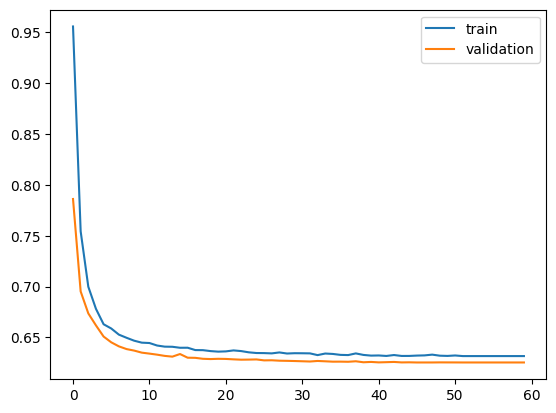

U-Net++ Metrics
Trainable Parameters: 19142
Mean IoU: 0.94 +/- 0.01
Mean Hausdorff Distance: 8.83 +/- 2.81


In [ ]:
metrics(unet_plus_plus, "U-Net++", unet_plus_plus_train_losses, unet_plus_plus_val_losses, unet_plus_plus_mean_ious, unet_plus_plus_mean_hds, 60)

In [25]:
mean_ious = [0.9230995460792825, 0.93895599577162, 0.9389442408526385, 0.9477417168793855, 0.9440615088851364]
print(f"Mean IoU: {np.mean(mean_ious) * 100:.2f} +/- {np.std(mean_ious)* 100:.2f}")

Mean IoU: 93.86 +/- 0.84
